<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Line-intersection" data-toc-modified-id="Line-intersection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Line intersection</a></span></li><li><span><a href="#Benchmark---putting-stuff-on-the-GPU" data-toc-modified-id="Benchmark---putting-stuff-on-the-GPU-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Benchmark - putting stuff on the GPU</a></span></li><li><span><a href="#Raycaster---Parallelizing-segments-and-poses" data-toc-modified-id="Raycaster---Parallelizing-segments-and-poses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Raycaster - Parallelizing segments and poses</a></span><ul class="toc-item"><li><span><a href="#CPU-version" data-toc-modified-id="CPU-version-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CPU version</a></span></li><li><span><a href="#CUDA-version" data-toc-modified-id="CUDA-version-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CUDA version</a></span></li><li><span><a href="#Combined-version" data-toc-modified-id="Combined-version-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Combined version</a></span></li><li><span><a href="#Examples" data-toc-modified-id="Examples-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Examples</a></span></li></ul></li></ul></div>

# CUDA 2D Raycaster for Line Maps

Here we implement a 2D raycaster for *line maps* in Julia. We develop both a CPU-based version and a CUDA-accelerated version, utilizing the parallel computing capabilities of NVIDIA GPUs, to improve performance.

We export three main functions: 
- `cast_cpu` the CPU-based version, 
- `cast_cu` the CUDA-accelerated version, and 
- `cast`, which automatically switches between CPU and CUDA acceleration.

**Runtime comparison: GPU -vs- CPU**

When creating observations in an environment consisting of **500** random line segments at **500** random poses, the CPU implementation takes approximately **640.173 ms**, whereas the GPU-accelerated version achieves the same task in just **2.008 ms**.

In a scenario with **1,000** random line segments at a **single** random pose, the CPU implementation requires around **2.568 ms**, while the GPU version takes **211.702 μs**.


**Cuda availability**

Chek if we have a GPU that is compatible with CUDA.
In a module one can add the following snippet (`__init__` will then be automatically called)
```julia
const _cuda = Ref(false)
function __init__()
    _cuda[] = CUDA.functional()
end;
```

> Reference: https://cuda.juliagpu.org/stable/installation/conditional/


In [2]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [1]:
#nbx --fname="src/cuda_raycaster_line_map_b.jl"
push!(LOAD_PATH, "src");
using MyUtils
using CUDA
using MyCudaUtils
using BenchmarkTools
using Colors, Plots
col = palette(:default);
import Base: @doc


## Line intersection

To do raycsting we need to compute the intersection of two lines by solving: $x + s \cdot dx = y + t \cdot dy$.

Implementation from my `Geometry.jl` package:

```julia
function line_intersect(x, x′, y, y′)
    dx = x′ - x
    dy = y′ - y
    v  = x - y
    if det([-dx dy]) == 0
        return [Inf;Inf]
    end
    s, t = inv([-dx dy])*v
    return s,t
end;
```

And here's a version without arrays that we can use within a cuda kernel later.

In [5]:
#nbx
function line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
    dx1, dx2 = x1′ - x1, x2′ - x2
    dy1, dy2 = y1′ - y1, y2′ - y2
    
    v1 = (x1 - y1)
    v2 = (x2 - y2)
    
    a, b = -dx1, dy1
    c, d = -dx2, dy2
    
    det = a*d - c*b
    
    if det == 0
        return Inf,Inf
    end
    
    s = 1/det*(  d*v1 - b*v2)
    t = 1/det*(- c*v1 + a*v2)

    return s,t
end;

## Benchmark - putting stuff on the GPU

Just check if moving between CPU and GPU becomes a bottleneck.

In [6]:
@btime      CuArray($(ones(100,100,100))) samples=3 evals=3;
@btime      CuArray{Float64}(undef, 100,100,100) samples=3 evals=3;
@btime Inf.*CuArray{Float64}(undef, 100,100,100) samples=4 evals=4;
@btime Inf *CuArray{Float64}(undef, 100,100,100) samples=4 evals=4;
@btime Inf.*CUDA.ones(100,100,100) samples=4 evals=4;
@btime Inf *CUDA.ones(100,100,100) samples=4 evals=4;

  848.710 μs (4 allocations: 176 bytes)
  3.931 μs (4 allocations: 176 bytes)
  84.180 μs (33 allocations: 2.09 KiB)
  15.379 μs (33 allocations: 2.09 KiB)
  23.930 μs (35 allocations: 2.12 KiB)
  20.620 μs (35 allocations: 2.12 KiB)


```julia
CuArray   824.838 μs (4 allocations: 176 bytes)
            4.030 μs (4 allocations: 176 bytes)
           86.347 μs (33 allocations: 2.09 KiB)
           16.236 μs (33 allocations: 2.09 KiB)
           25.285 μs (35 allocations: 2.12 KiB)
CUDA.ones  22.581 μs (35 allocations: 2.12 KiB)
```

In [7]:
function bench_cuarray(x,y,z)
    x_  = CuArray(x)
    y_  = CuArray(y)
    z_  = CuArray(z)
end

n = 1_000
m = 1_000
x = rand(n,2)
y = rand(m,4)
z = rand(n,4)

bs = []
for e=1:6
    n = 10^e
    x = rand(n,2)
    y = rand(n,2);
    z = rand(n,2);
    b = @benchmark bench_cuarray($x,$y,$z) samples=3 evals=3;
    push!(bs, b)
end

mean.(bs)

6-element Vector{BenchmarkTools.TrialEstimate}:
 30.206 μs
 31.277 μs
 42.085 μs
 125.183 μs
 725.022 μs
 5.460 ms

```julia
10   >> 33.175 μs
10^2 >> 32.889 μs
10^3 >> 36.669 μs
10^4 >> 134.479 μs
10^5 >> 753.159 μs
10^6 >> 6.102 ms
```

## Raycaster - Parallelizing segments and poses

### CPU version

In [8]:
#nbx
function cast_cpu!(Z, X, P, fov=2π)
    num_a = size(Z,2)
    r     = fov/(num_a-1)
    
    for i = 1:size(X,1), j = 1:size(P,1)
        # Todo: Can I somehow reuse this code block in the cuda kernel?
        
        
        # convert everything into pose coords
        x1 , x2  = X[i,1] - P[j,1], X[i,2] - P[j,2]
        x1′, x2′ = X[i,3] - P[j,1], X[i,4] - P[j,2]
        dx1, dx2 = x1′-x1, x2′-x2
        y1 , y2  = 0, 0
        a1 = atan(x2 , x1 ) - P[j,3]
        a2 = atan(x2′, x1′) - P[j,3]
        a1 = mod(a1 + π, 2π) - π
        a2 = mod(a2 + π, 2π) - π

        # Ensure a1 < a2
        if a1 > a2
            a1, a2 = a2, a1
        end
        
        # Check if we cross from `-π+a` to `π-b`
        if a2 - a1 > π
            # Get the start end end bin
            zero = - fov/2;
            k1 = Int(floor((-π + r/2 - zero)/r))+1
            k2 = Int(floor((a1 + r/2 - zero)/r))+1
            
            k1′ = Int(floor((a2 + r/2 - zero)/r))+1
            k2′ = Int(floor((π + r/2 - zero)/r))+1
            
            ks = ((k1,k2),(k1′,k2′))
        else
            # Get the start end end bin
            zero = - fov/2;
            k1 = Int(floor((a1 + r/2 - zero)/r))+1
            k2 = Int(floor((a2 + r/2 - zero)/r))+1
            
            ks = ((k1,k2),)
            
        end
        
        
        for (k1,k2) in ks, k = k1:k2
            if !(1 <= k <= num_a)
               continue 
            end

            a = zero + (k-1)*r + P[j,3] 
            y1′, y2′ = cos(a), sin(a)

            s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
            if 0 < t && 0 <= s <= 1    
                @inbounds Z[j,k] = min(Z[j,k], t)
            end
        end
    end
    return
end


"""
```julia
    zs = cast_cpu(ps, segs; fov=2π, num_a::Int=361, zmax::Float64=Inf)
```
Computes depth measurements `zs` with respect to a family of stacked poses `ps`
and family of stacked line segments `segs_` along a fixed number `num_a` of
equidistantly spaced angles in the field of view `fov`.

Arguments:
 - `ps`: Stacked poses `(k, 3)`
 - `segs`: Stacked line segments `(n, 4)`
 - ...

Returns:
 - `zs`: Depth measurements in the field of view `(k, num_a)`
"""
function cast_cpu(ps, segs; fov=2π, num_a::Int=361, zmax::Float64=Inf)
    zs = fill(zmax, size(ps, 1), num_a)
    cast_cpu!(zs, segs, ps, fov)
    return zs
end;

export cast_cpu

### CUDA version

In [22]:
#nbx
function cast_kernel!(Z, X, P, fov=2π)

    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
            
    num_a = size(Z,2)
    r     = fov/(num_a-1)
    
    for i = ix:sx:size(X,1), j = iy:sy:size(P,1)
        
        # convert everything into pose coords
        x1 , x2  = X[i,1] - P[j,1], X[i,2] - P[j,2]
        x1′, x2′ = X[i,3] - P[j,1], X[i,4] - P[j,2]
        dx1, dx2 = x1′-x1, x2′-x2
        y1 , y2  = 0, 0
        a1 = atan(x2 , x1 ) - P[j,3]
        a2 = atan(x2′, x1′) - P[j,3]
        a1 = mod(a1 + π, 2π) - π
        a2 = mod(a2 + π, 2π) - π

        # Ensure a1 < a2
        if a1 > a2
            a1, a2 = a2, a1
        end
        

        # Check if we cross from `-π+a` to `π-b`
        if a2 - a1 > π
            # Get the start end end bin
            zero = - fov/2;
            k1 = Int(floor((-π + r/2 - zero)/r))+1
            k2 = Int(floor((a1 + r/2 - zero)/r))+1
            
            k1′ = Int(floor((a2 + r/2 - zero)/r))+1
            k2′ = Int(floor((π + r/2 - zero)/r))+1
            
            ks = ((k1,k2),(k1′,k2′))
        else
            # Get the start end end bin
            zero = - fov/2;
            k1 = Int(floor((a1 + r/2 - zero)/r))+1
            k2 = Int(floor((a2 + r/2 - zero)/r))+1
            
            ks = ((k1,k2),)
            
        end
        
        
        for (k1,k2) in ks, k = k1:k2
            if !(1 <= k <= num_a)
               continue 
            end

            a = zero + (k-1)*r + P[j,3] 
            y1′, y2′ = cos(a), sin(a)

            s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
            if 0 < t && 0 <= s <= 1    
                @inbounds CUDA.@atomic Z[j,k] = min(Z[j,k], t)
            end


        end
    end
    return
end


function cast_cu!(Z, X, P; fov=2π, blockdims=(16,16))
    n = size(X,1)
    m = size(P,1)
    
    griddims = cuda_grid((n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast_kernel!(Z, X, P, fov)
    end
end


"""
```julia
    zs_ = cast_cu(ps_::CuArray, segs_::CuArray; fov=2π, num_a::Int=361, zmax::Float64=Inf)
```
Computes depth measurements `zs_` with respect to a family of stacked poses `ps_`
and family of stacked line segments `segs_` along a fixed number `num_a` of
equidistantly spaced angles in the field of view `fov`.

Arguments:
 - `ps_`: Stacked poses `(k, 3)`
 - `segs_`: Stacked line segments `(n, 4)`
 - ...

Returns:
 - `zs_`: Depth measurements in the field of view `(k, num_a)`
"""
function cast_cu(ps_::CuArray, segs_::CuArray; fov=2π, num_a::Int=361, zmax::Float64=Inf, blockdims=(16,16))
    zs_ = zmax*CUDA.ones(size(ps_, 1), num_a)
    cast_cu!(zs_, segs_, ps_; fov=fov, blockdims=blockdims)
    return zs_
end;

export cast_cu

In [35]:
n = 500 # num segments
m = 500 # num poses
x = 5*(2*rand(n,4).-1.0)
p = zeros(m, 3)
z = ones(m, 360)
    


x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_,1)
m = size(p_,1)
datadims  = (n,m)
blockdims = (16,16)
griddims  = cuda_grid(datadims, blockdims)

# -------------------------------
println("x: $(size(x)), p: $(size(p))")
println("data dims: $(datadims), block dims: $(blockdims), grid: $(griddims)")
println("`cast_cpu!`")
@btime cast_cpu!($z,$x,$p) samples=3 evals=3;
println("`cast_cu`")
@btime cast_cu!($z_,$x_,$p_; blockdims=(16,16)) samples=3 evals=3;
@btime cast_cu!($z_,$x_,$p_; blockdims=(8,32)) samples=3 evals=3;
@btime cast_cu!($z_,$x_,$p_; blockdims=(4,64)) samples=3 evals=3;

x: (500, 4), p: (500, 3)
data dims: (500, 500), block dims: (16, 16), grid: (32, 32)
`cast_cpu!`
  627.775 ms (0 allocations: 0 bytes)
`cast_cu`
  1.981 ms (74 allocations: 4.33 KiB)
  1.671 ms (74 allocations: 4.33 KiB)
  1.442 ms (74 allocations: 4.33 KiB)


In [47]:
n = 1000 # num segments
m = 1    # num poses
x = 5*(2*rand(n,4).-1.0)
p = zeros(m, 3)
z = ones(m, 360)
    


x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_,1)
m = size(p_,1)
datadims  = (n,m)
blockdims = (16,16)
griddims  = cuda_grid(datadims, blockdims)

# -------------------------------
println("x: $(size(x)), p: $(size(p))")
println("data dims: $(datadims), block dims: $(blockdims), grid: $(griddims)")
println("`cast_cpu!`")
@btime cast_cpu!($z,$x,$p) samples=3 evals=3;
println("`cast_cu`")
@btime cast_cu!($z_,$x_,$p_; blockdims=(64,4)) samples=3 evals=3;

x: (1000, 4), p: (1, 3)
data dims: (1000, 1), block dims: (16, 16), grid: (63, 1)
`cast_cpu!`
  2.524 ms (0 allocations: 0 bytes)
`cast_cu`
  223.710 μs (26 allocations: 1.39 KiB)


### Combined version

2D raycaster for *line maps* in Julia, which automatically switches between CPU and CUDA acceleration.



In [19]:
#nbx
create_angles(fov, num_a) = [range(-fov/2, fov/2, num_a)...];
export create_angles

In [ ]:
#nbx
"""
```julia
    zs = cast(ps, segs; fov=2π, num_a::Int=361, zmax::Float64=Inf)
```
Computes depth measurements `zs` with respect to a family of stacked poses `ps`
and family of stacked line segments `segs` along a fixed number `num_a` of
equidistantly spaced angles in the field of view `fov`.

If a CUDA supported GPU is available we run a GPU accelerated version.

Arguments:
 - `ps`: Stacked poses `(k, 3)`
 - `segs`: Stacked line segments `(n, 4)`
 - ...

Returns:
 - `zs`: Depth measurements in the field of view `(k, num_a)`
"""
function cast(ps::Array, segs::Array; fov=2π, num_a::Int=361, zmax::Float64=Inf)
    if _cuda[]
        ps_   = CuArray(ps)
        segs_ = CuArray(segs)
        zs_   = cast_cu(ps_, segs_; fov=fov, num_a=num_a, zmax=zmax)
        return Array(zs_)
    else
        return cast_cpu(ps, segs; fov=fov, num_a=num_a, zmax=zmax)
    end
end;

function cast(ps_::CuArray, segs_::CuArray; fov=2π, num_a::Int=361, zmax::Float64=Inf)
    return cast_cu(ps_, segs_; fov=fov, num_a=num_a, zmax=zmax)
end

export cast

In [ ]:
n = 500 # num segments
m = 500 # num poses
x = 5*(2*rand(n,4).-1.0)
p = zeros(m, 3)

# -------------------------------
println("CUDA available: $(_cuda[])")
println("x: $(size(x)), p: $(size(p))")
println("`cast`")
@btime cast($p,$x) samples=3 evals=3;

### Examples

In [33]:
include("./src/pose.jl");
using Geometry: Segment

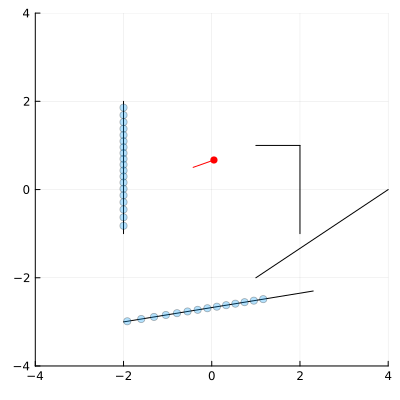

In [34]:
segs = [
    Segment([1.,1.,2.,1.]),
    Segment([2.,1.,2.,-1.]),
    Segment([1.,-2.,4.,0.]),
    Segment([-2.,2.,-2.,-1.]),
    Segment([-2.,-3.,2.3,-2.3]),
]

m     = 10
fov   = π
num_a = 50

ps = [Pose(rand(2), rand()*2π) for i=1:m]

zs = cast(stack(Vector.(ps)), stack(Vector.(segs)); fov=fov, num_a=num_a, zmax=Inf)
as = create_angles(fov, num_a)
zs = unstack(zs)
ys = polar_inv.(zs,[as])

# ----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing, 
    xlim=(-4,4),
    ylim=(-4,4)
)
plot!(segs, c=:black)
scatter!(ys[1].*ps[1], c=col[1], alpha=0.3)
scatter!(ps[1], r=0.5, c=:red, alpha=1.)

    